In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import warnings
warnings.filterwarnings('ignore')

In [2]:
DATA_PATH = "../../01_data/processed/final_ml_feature_matrix.csv"
TARGET_COLUMN = 'Status_Code' # This is the target column from your R script
RANDOM_STATE = 42

In [3]:
df = pd.read_csv(DATA_PATH, index_col=0)

In [4]:
numeric_cols = df.select_dtypes(include=np.number).columns.tolist()
print(f"Features loaded: {len(numeric_cols)} (CLR OTUs + Diversity Metrics)")

Features loaded: 84 (CLR OTUs + Diversity Metrics)


In [5]:
clr_columns = [col for col in df.columns if col.startswith('CLR_')]
ALPHA_COLUMNS = ['Shannon_Index', 'Observed_Richness']
X_columns = clr_columns + ALPHA_COLUMNS

X = df[X_columns]
y_raw = df[TARGET_COLUMN]

In [6]:
le = LabelEncoder()
y = le.fit_transform(y_raw)
class_labels = le.classes_

In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=RANDOM_STATE, stratify=y
)

In [8]:
rf_model = RandomForestClassifier(
    n_estimators=500, max_depth=10, random_state=RANDOM_STATE, n_jobs=-1
)
rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf, average='weighted')

print(f"RF Model Accuracy: {accuracy_rf:.4f}")
print(f"RF Model F1-Score (Weighted): {f1_rf:.4f}")

RF Model Accuracy: 0.8182
RF Model F1-Score (Weighted): 0.8182


In [9]:
print(classification_report(y_pred_rf, y_test))

              precision    recall  f1-score   support

           0       0.91      0.91      0.91        11
           1       0.83      0.83      0.83        12
           2       0.70      0.70      0.70        10

    accuracy                           0.82        33
   macro avg       0.81      0.81      0.81        33
weighted avg       0.82      0.82      0.82        33



In [10]:
cm_rf = confusion_matrix(y_test, y_pred_rf)
cm_df_rf = pd.DataFrame(cm_rf, index=class_labels, columns=class_labels)

print("\nRF Confusion Matrix (Predicted vs. True):\n")
print(cm_df_rf)


RF Confusion Matrix (Predicted vs. True):

       bbv  bcont  bvvc
bbv     10      0     1
bcont    0     10     2
bvvc     1      2     7


In [11]:
xgb_model = XGBClassifier(
    n_estimators=500, 
    learning_rate=0.05, 
    max_depth=5, 
    random_state=RANDOM_STATE, 
    objective='multi:softmax', 
    num_class=len(class_labels),
    use_label_encoder=False,
    eval_metric='mlogloss'
)
xgb_model.fit(X_train, y_train)

y_pred_xgb = xgb_model.predict(X_test)
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
f1_xgb = f1_score(y_test, y_pred_xgb, average='weighted')

print(f"XGB Model Accuracy: {accuracy_xgb:.4f}")
print(f"XGB Model F1-Score (Weighted): {f1_xgb:.4f}")

XGB Model Accuracy: 0.7879
XGB Model F1-Score (Weighted): 0.7865


In [12]:
print(classification_report(y_pred_xgb, y_test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        11
           1       0.75      0.69      0.72        13
           2       0.60      0.67      0.63         9

    accuracy                           0.79        33
   macro avg       0.78      0.79      0.78        33
weighted avg       0.79      0.79      0.79        33



In [13]:
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
cm_df_xgb = pd.DataFrame(cm_xgb, index=class_labels, columns=class_labels)

print("\nXGB Confusion Matrix (Predicted vs. True):\n")
print(cm_df_xgb)


XGB Confusion Matrix (Predicted vs. True):

       bbv  bcont  bvvc
bbv     11      0     0
bcont    0      9     3
bvvc     0      4     6


In [20]:
model_names = ["Random Forest","XGBoost"]
accuracies = [accuracy_rf,accuracy_xgb]
f1_scores = [f1_rf,f1_xgb]

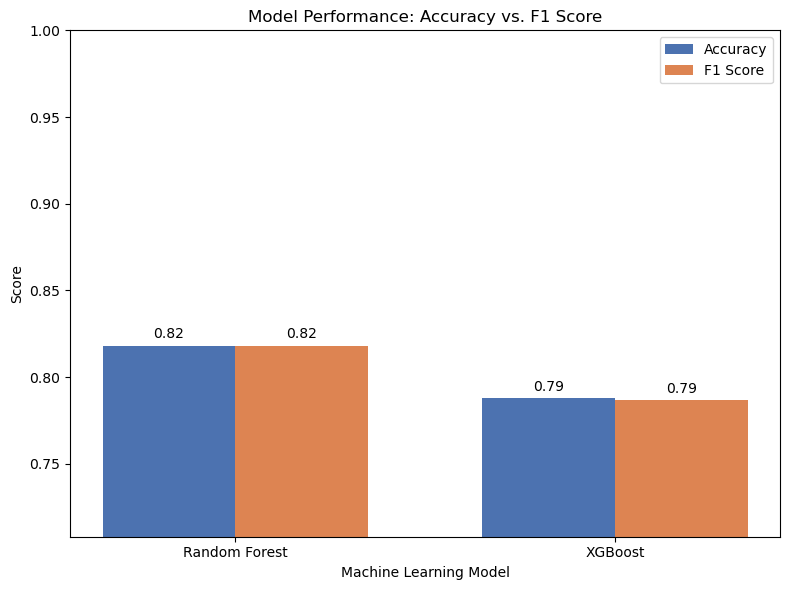

In [22]:
labels = model_names
x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(8, 6))
rects1 = ax.bar(x - width/2, accuracies, width, label='Accuracy', color='#4c72b0')
rects2 = ax.bar(x + width/2, f1_scores, width, label='F1 Score', color='#dd8452')

ax.set_ylabel('Score')
ax.set_xlabel('Machine Learning Model')
ax.set_title('Model Performance: Accuracy vs. F1 Score')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
ax.set_ylim(min(accuracies + f1_scores) * 0.9, 1.0) # Set a sensible y-limit

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.savefig('model_performance_grouped_bar_plot.png')

In [14]:
feature_importance = pd.Series(xgb_model.feature_importances_, index=X_train.columns)
top_10_features = feature_importance.nlargest(10)

<BarContainer object of 10 artists>

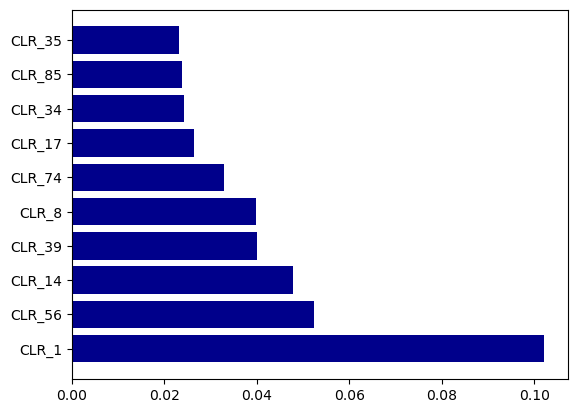

In [15]:
plt.barh(top_10_features.index, top_10_features.values, color='darkblue')

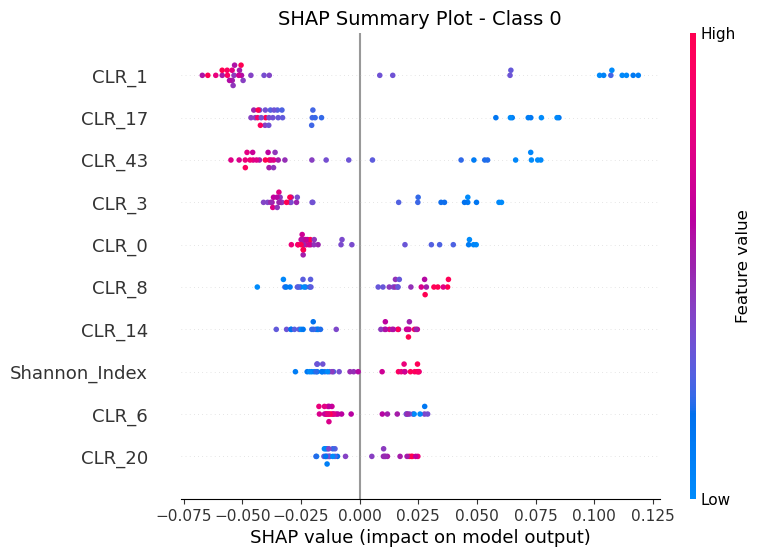

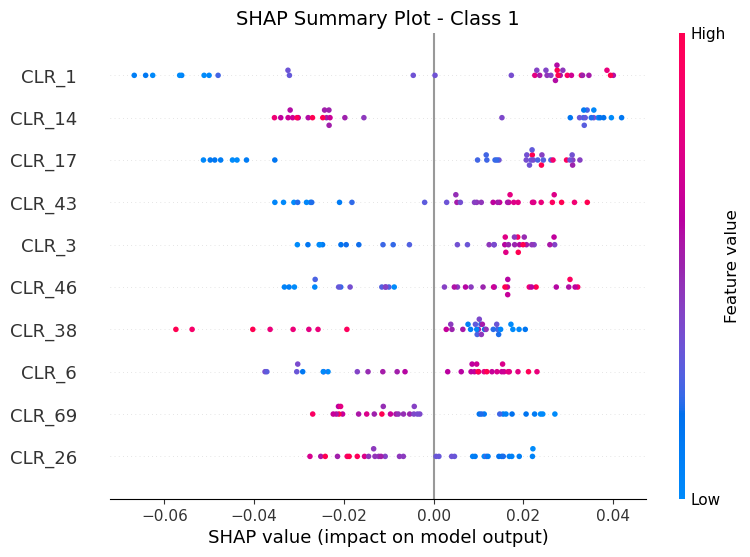

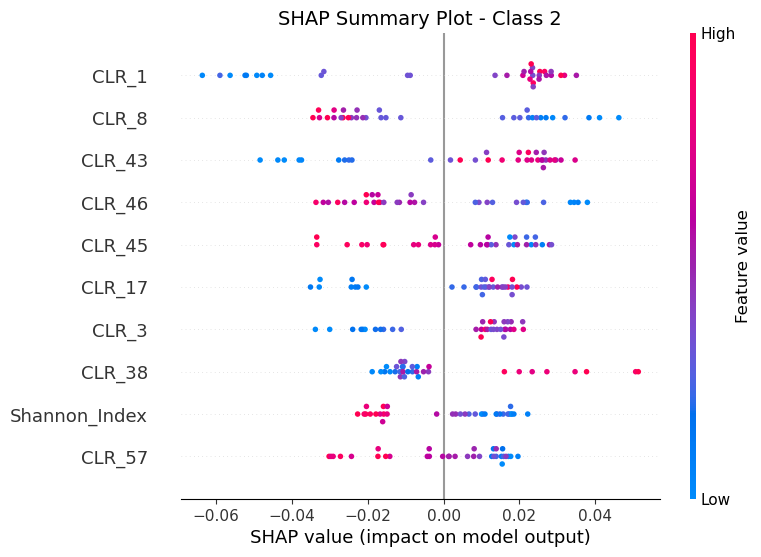

In [17]:
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_test)

# shap_values shape: (n_samples, n_features, n_classes)
n_classes = shap_values.shape[2]

for class_idx in range(n_classes):
    class_shap = shap_values[:, :, class_idx]  # shape: (33, 79)
    
    plt.figure()
    shap.summary_plot(
        class_shap,
        X_test.values,
        feature_names=X_test.columns.tolist(),
        max_display=10,
        show=False
    )
    plt.title(f"SHAP Summary Plot - Class {class_idx}", fontsize=14)
    plt.savefig(f"shap_class_{class_idx}.png", bbox_inches='tight')


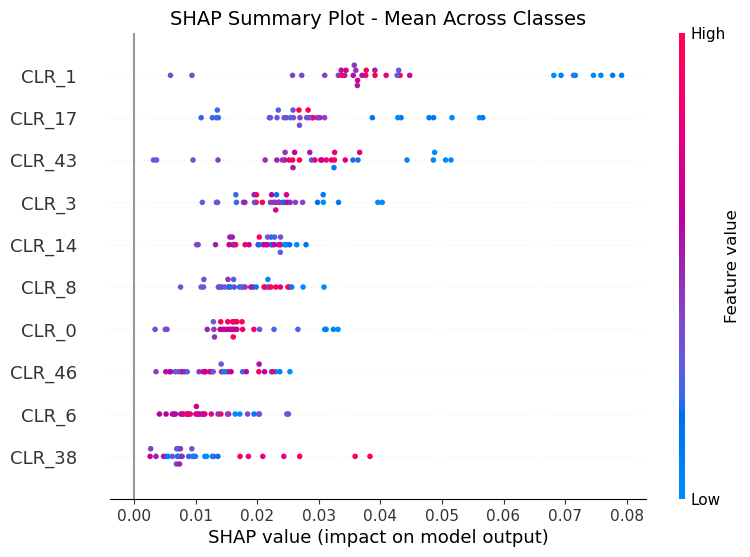

In [18]:
# Compute mean absolute SHAP across classes
mean_abs_shap = np.mean(np.abs(shap_values), axis=2)  # shape: (33, 79)

plt.figure()
shap.summary_plot(
    mean_abs_shap,
    X_test.values,
    feature_names=X_test.columns.tolist(),
    max_display=10,
    show=False
)
plt.title("SHAP Summary Plot - Mean Across Classes", fontsize=14)
plt.savefig("shap_mean_across_classes.png", bbox_inches='tight')


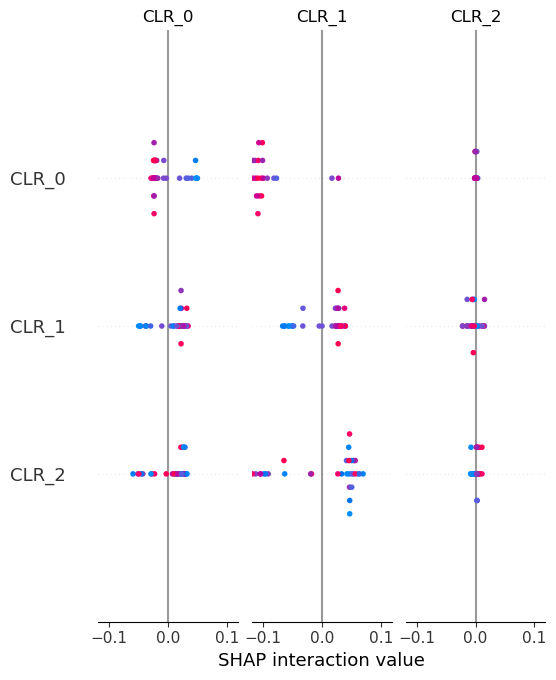

In [19]:
shap.summary_plot(shap_values, X_test)